# OTU plotting module NMDS DEV v1.4

### v. 1.4, clean up dev of  env. loadings arrows

In [1]:
# Here for SF_Sal_OTU 
# can make pipelined version when DESeq2 norm module is complete

# v 1.1 cleans up function ordering further, toward modules

## NMDS plotting only version 
 ##### Need to combine custom and default color palletes with if/else?
 Make function by wrapping everything from OTU, Meta, Col_var, Shape_var, Colors -- could customize for more shapes... 

In [2]:
# Import packagaes

library(ggplot2)
library(RColorBrewer)
library(reshape2)

suppressMessages(library(gtools))
suppressMessages(library(vegan))
suppressMessages(library(gplots))

#library(phyloseq)
#library(stringr)
#suppressMessages(library(DESeq2))
#suppressMessages(library(Hmisc))
#suppressMessages(library(cowplot))
#theme_set(theme_grey())  # important, overwrites cowplot defaults, which add items to plots


## Load data for testing

### Get OTU table (DESeq VST CPM)

In [3]:
# Import OTU Table
OTU_v <- read.table("SF_Sal_OTU_VSTcpm.txt", sep='\t', header=T, row.names=1)                   # dim(OTU_v); head(OTU_v)

# Sort OTU table                                                                      
otu_V <-OTU_v[order(OTU_v$Consensus.lineage),]                                  # sort by lineage  

In [4]:
#dim(otu_V)

# Drop Sandmound Cattail samps
#otu_V <- otu_V[, (colnames(otu_V) !='Sandmound_CattailA_D1')]
#otu_V <- otu_V[, (colnames(otu_V) !='Sandmound_CattailA_D2')]
                  
#dim(otu_V)
#c(names(otu_V))

### Get metadata mapping file

In [5]:
# Import Sample mapping
metaDB <-read.table("SF_sal_meta_FIX3b_gap_fill_MDS.txt", sep="\t", header=TRUE)          # Import Metadata, keep all    
#metaDB <-read.table("SF_sal_meta_FIX3b.txt", sep="\t", header=TRUE)          # Import Metadata, keep all    
row.names(metaDB) <- metaDB$Sample                                          # Row names are samples for phyloseq             
metaDB = metaDB[,-1]      

In [6]:
# head(metaDB)

### Correct metadata, gap-Filling and log transforms 

In [7]:
## Manually filled: 
#    NO3_N, Fe, Mn, Cu, Zn

## To be gapfilled (0.5*min): 
# NO2_pw, NO3_pw, NH3_pw, PO4_pw,#  Zn_pw, K_pw

In [8]:
# Simple gapfilling function
min_fill = function(col){

    vect <- metaDB[col]
    vect[is.na(vect)] <- min(vect[!is.na(vect)])*0.5
    metaDB[col] <- vect
    return(metaDB)   
}

# need an lapply here.
metaDB <- min_fill("NO2_pw")
metaDB <- min_fill("NO3_pw")
metaDB <- min_fill("NH3_pw")
metaDB <- min_fill("PO4_pw")

#fill_cols <- c("NO2_pw", "NO3_pw", "NH3_pw", "PO4_pw")
#metaDB[fill_cols]

In [9]:
metaDB["NP_pw"] <- (metaDB["NO2_pw"] + metaDB["NO3_pw"] + metaDB["NH3_pw"]) /14/(metaDB["PO4_pw"]/31)
# metaDB["NP_pw"]
metaDB["NC"] <- metaDB["N"]/14 /(metaDB["NO3_pw"]/12)


In [10]:
dim(metaDB)

[1] 170  69

### Reduce metadata to match dim of OTU table

In [11]:
## Meta_iTag needed for subsequent, MOVE UP to top
# Get Sample names in OTU table               
OTU_samps <- data.frame('Sample'=colnames(OTU_v))                #OTU_samps

# Merge site order and Samples
Meta_iTag <- merge(metaDB, OTU_samps, by='Sample')               #colnames(metaDB)
rownames(Meta_iTag) <- Meta_iTag$Sample

# Reorder location factor
Meta_iTag$Location <-factor(Meta_iTag$Location, levels=c("Sandmound","WestPond","Mayberry","Browns","RushRanch","Joice","Goodyear","WhiteSlough","Tolay","ChinaCamp","Muzzi"))  #head(Meta_iTag)
Meta_iTag$Pl_Sp <-factor(Meta_iTag$Pl_Sp, levels=c("Cattail","Tule","ThreeSq","CattailNL","Phrag","PW","Cord"))

# Resort meta itag by index
indexer = 'EWsiteHyd_index'
Meta_iTag <- Meta_iTag[order(Meta_iTag[indexer]),]
# colnames(Meta_iTag)

# Prepare data, cats for NMDS plot  -- move up to top or in function?
Location <-Meta_iTag$Location                                                    # Get Location vector from meta_iTag
Restor <- Meta_iTag$EWcoastGroup
Plant <- Meta_iTag$Pl_Sp
# Plant

### Get Site Colors

In [12]:
# Import site colors
site_colors <- read.table("Sal_siteColors_testR.txt", sep='\t', header=T, row.names=1)          # site_colors
site_colours <- (site_colors$Salpal3_col)                                                       # only color

# Get list from vector, move inside functions?
site_col <- levels(site_colours)[as.numeric(site_colours)]  # collect levels, as.numeric preserves ordering
site_col

[1] "#3f4c1d" "#63703a" "#2c9553" "#275831" "#3e797c" "#235355" "#5f9c9e"
 [8] "#6c92b2" "#64679d" "#412142" "#8e5589"

# 1) NMDS plots

In [32]:
# Reset levels for ref and restored wetlands
levels(Meta_iTag$EWcoastGroup) <-c("Historic", "Restored")
# Meta_iTag$EWcoastGroup

# Prepare data, cats for NMDS plot  -- move up? or needed in function.
Location <-Meta_iTag$Location                                                    # Get Location vector from meta_iTag
Restor <- Meta_iTag$EWcoastGroup
Plant <- Meta_iTag$Pl_Sp

# move below inside function)
counts <- sapply(otu_V, is.numeric)                                             # Select numeric columns
otu_d <- data.matrix(otu_V[,counts])                                            # Filter from OTU tab          #length(Restor) #length(Plant) #dim(otu_d)

In [33]:
# Variable abstractions, as used in previous function
biom <-otu_d  
biomT<-t(biom)    # Transpose so cols are vars
group <- Location
shape_var <- Restor
#bT_adonis <- adonis(biomT  ~ group, permutations=99, method="bray")
# biomT

In [34]:
# NMDS method
  bT_mds<-metaMDS(biomT[,-1], distance="bray",k=3, trymax=10);                  # run NMDS
  bT_mds_DF = data.frame(NMDS1=bT_mds$points[,1], NMDS2=bT_mds$points[,2], group)  # Make data frame
  scrsO <- bT_mds_DF
  # scrsO$points
  # stress=round(bT_mds$stress, digits = 3)                                      # get NMDS stress
  # bT_mds$scores

Square root transformation
Wisconsin double standardization
Run 0 stress 0.06594869 
Run 1 stress 0.06582525 
... New best solution
... Procrustes: rmse 0.004568468  max resid 0.05547789 
Run 2 stress 0.06582639 
... Procrustes: rmse 0.0002575094  max resid 0.002050837 
... Similar to previous best
Run 3 stress 0.06594758 
... Procrustes: rmse 0.004560791  max resid 0.05554803 
Run 4 stress 0.06594813 
... Procrustes: rmse 0.004518147  max resid 0.0553501 
Run 5 stress 0.06582583 
... Procrustes: rmse 0.0001552463  max resid 0.001095495 
... Similar to previous best
Run 6 stress 0.06582574 
... Procrustes: rmse 0.0001332384  max resid 0.001085712 
... Similar to previous best
Run 7 stress 0.06582383 
... New best solution
... Procrustes: rmse 0.0003438311  max resid 0.002604169 
... Similar to previous best
Run 8 stress 0.06582473 
... Procrustes: rmse 0.0001677793  max resid 0.001337837 
... Similar to previous best
Run 9 stress 0.06594785 
... Procrustes: rmse 0.004565625  max resid 

In [35]:
chem_cols <- sapply(Meta_iTag, is.numeric)  
Env_chem <- Meta_iTag[chem_cols]
names(Env_chem)
dim(Env_chem)
#names(Env_chem[5:40])
#names(Env_chem[5:30])

[1] "EWsiteHyd_index"  "Index"            "EW.no"            "Site_indx"       
 [5] "Salinity.x"       "Bulk_dens"        "H2O_FPS"          "CO2_mg_m2_h"     
 [9] "CO2_soilC_mg_g_d" "CH4_ug_m2_h"      "CH4_CO2"          "CH4_soilC_ug_g_d"
[13] "pH"               "Cl"               "SO4"              "Corg_LOI"        
[17] "C"                "N"                "P"                "NO3_N"           
[21] "NH4_N"            "Olsen_P"          "CN"               "CP"              
[25] "NP"               "NP_ext"           "NO3_NH4"          "C_g_m2"          
[29] "N_g_m2"           "P_g_m2"           "Fe"               "Mn"              
[33] "Cu"               "Zn"               "Salinity.y"       "CO2_mg_m2_h.1"   
[37] "CH4_ug_m2_h.1"    "Cl_pw"            "SO4_pw"           "DOC_mg_L"        
[41] "NO2_pw"           "NO3_pw"           "NH3_pw"           "PO4_pw"          
[45] "Fe_pw"            "Mn_pw"            "Co_pw"            "Cu_pw"           
[49] "Zn_pw"            "Ca_pw"            "Sr_pw"            "Mg_pw"           
[53] "Na_pw"            "K_pw"             "Al_pw"            "Si_pw"           
[57] "Br_pw"            "F_pw"             "NP_pw"            "NC"

[1] 168  60

In [36]:
#keep_vars <-c('Salinity.x', 'Bulk_dens', 'H2O_FPS','CO2_mg_m2_h', 'CH4_ug_m2_h', 'C', 'N', 'P', 
#              'NO3_N', 'NH4_N', 'Olsen_P', 'CN', 'CP', 'NP', 'NP_ext',
#              'NO3_NH4', 'DOC_mg_L','NO2_pw','NO3_pw','NH3_pw', 'Co_pw','Cu_pw')

#keep_vars <-c('Salinity.x', 'Bulk_dens', 'CO2_mg_m2_h', 'CH4_ug_m2_h', 'C', 'N', 'P', 'C_g_m2', 'N_g_m2', 
#               'CN', 'NP', 'NO3_N', 'NH4_N', 'DOC_mg_L', 'NO2_pw','NO3_pw','NH3_pw','PO4_pw', 'NP_pw', 'NC')#,


keep_vars <-c('Salinity.x', 'Bulk_dens', 'CO2_mg_m2_h', 'CH4_ug_m2_h', 'C', 'N', 'P', 'N_g_m2', #'C_g_m2', 
              'NP', 'NO3_N', 'NH4_N', 'DOC_mg_L', 'NO2_pw','NO3_pw','NH3_pw','NC')#,
Env_chem <-Env_chem[keep_vars]

### CAREFUL HERE, lazy renaming... comment out when testing newvars.
colnames(Env_chem) <-c('Salinity', 'BD', 'CO2', 'CH4', 'C', 'N', 'P', 'N_g/m2',                  #'C_m2', 
                       'N:P', 'NO3_s', 'NH4_s', 'DOC', 'NO2_pw','NO3_pw','NH3_pw','N:C')
head(Env_chem)

#Env_chem <- Env_chem[,5:30] ; #chem_cols <- sapply(Meta_iTag, is.numeric); #Env_chem <- Meta_iTag[chem_cols[5:30]]

,Salinity,BD,CO2,CH4,C,N,P,N_g/m2,N:P,NO3_s,NH4_s,DOC,NO2_pw,NO3_pw,NH3_pw,N:C
Sandmound_TuleA_D1,0.5934254,0.2653691,1.481020,4.4730640,14.90,1.068,0.104,425.1213,22.70859,0.120,33.42,9.863,0.9970,0.0255,2.034667,35.89916
Sandmound_TuleA_D2,0.5934254,0.2743267,1.481020,4.4730640,14.98,0.965,0.090,397.0879,23.71030,0.630,48.13,9.863,0.9970,0.0255,2.034667,32.43697
Sandmound_TuleB_D1,0.6026209,0.2479678,4.173351,-0.2829401,15.15,1.088,0.110,404.6835,21.87199,0.700,28.59,11.770,0.9795,0.0255,2.175333,36.57143
Sandmound_TuleB_D2,0.6026209,0.2584306,4.173351,-0.2829401,13.59,0.923,0.090,357.7972,22.67834,0.800,35.32,11.770,0.9795,0.0255,2.175333,31.02521
Sandmound_TuleC_D1,0.5664683,0.2404236,1.764464,0.9258838,16.45,1.103,0.114,397.7809,21.39552,0.420,30.00,17.800,0.7960,0.0255,5.118600,37.07563
Sandmound_TuleC_D2,0.5664683,0.2696643,1.764464,0.9258838,13.27,0.941,0.085,380.6312,24.48065,0.715,21.19,17.800,0.7960,0.0255,5.118600,31.63025


### Get env. Fit for NMDS

In [37]:
fitE <- envfit(bT_mds, Env_chem, perm=0, na.rm=TRUE)

scrsE <-as.data.frame(scores(fitE, display="vectors")) # Get scores
scrsE <-cbind(scrsE, var=row.names(scrsE))            # add Env var name   
scrsE <-data.frame(scrsE)                             # make DF

##### Rescale env. scores
range_x <- max(scrsO[,1]) - min(scrsO[,1])
range_y <- max(scrsO[,2]) - min(scrsO[,2])

scrsE$sNMDS1<-scrsE[,1]*(range_x/2)
scrsE$sNMDS2<-scrsE[,2]*(range_y/2)


In [38]:
# head(scrsE); row.names(scrsE)
# fitE
#sNMDS1<-scrsE[,1]*(range_x/2)
#sNMDS2<-scrsE[,2]*(range_y/2)

In [39]:
#install.packages("ggrepel")
#library("ggrepel")   

# NMDS with EnvFit arrows

In [40]:
options(repr.plot.width=6, repr.plot.height=4)

  # PLOT NMDS by group color, shape
  pA <- ggplot(scrsO) +
    geom_point(mapping = aes(x=NMDS1, y=NMDS2, color=group, shape=shape_var), alpha = 0.8) + #+ geom_point(alpha = 0.8) +
    stat_ellipse(mapping = aes(x=NMDS1, y=NMDS2, color=group), alpha = 0.8) #  level=0.95, + ggtitle(paste("ADONIS R2 =", R2, "Stress:", stress));
  pB <- pA + scale_color_manual(values = c(site_col)) + scale_shape_manual(values=c(19, 17))
  # pB

In [41]:
# pB

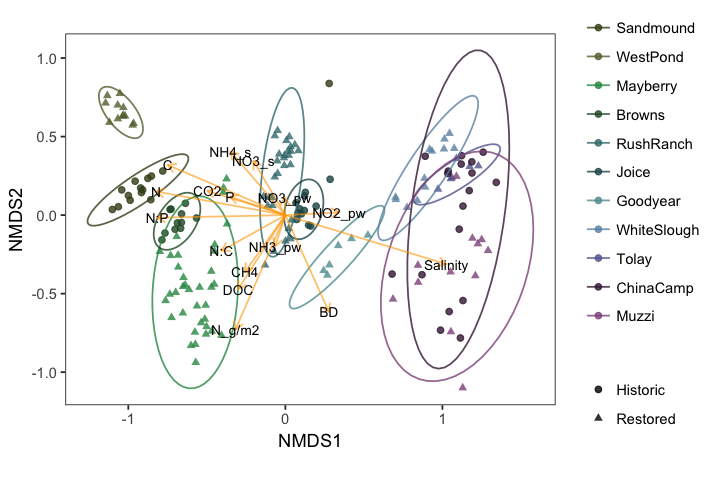

In [42]:
  pB + coord_fixed()+
       geom_segment(data = scrsE, aes(x = 0, xend = sNMDS1, y = 0, yend = sNMDS2), alpha=0.6,
              arrow = arrow(length = unit(0.2, "cm")), colour = "orange")                          + # +
       geom_text(data = scrsE, aes(x = sNMDS1, y = sNMDS2, label = var), size = 2.9)     +                           
       
    
       theme(legend.title=element_blank())       + 
       theme_bw() + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
                              legend.title=element_blank())  

In [43]:
ggsave("SF_Sal_OTU_NMDS_loadings_plot.pdf", width = 6, height = 4)

### NMDS with group, shape, custom pallete

In [25]:
#vec.sp<-envfit(sol$points, NMDS.log, perm=1000)
# plot(vec.sp, p.max=0.1, col="blue")

In [26]:
biom_plot_cats_nmds <- function(biom, group, shape_var, site_col){  # , env)
  biomT<-t(biom)    # Transpose so cols are vars
  
  # Test ADONIS models, extract params
  bT_adonis <- adonis(biomT  ~ group + shape_var, permutations=99, method="bray");#, data=env);
  R2 <- round(bT_adonis$aov.tab$R2[1], digits=3)
  P <- bT_adonis$aov.tab$"Pr(>F)"[1]
  
  # NMDS
  bT_mds<-metaMDS(biomT[,-1], distance="bray",k=3, trymax=10);                  # run NMDS
  bT_mds_DF = data.frame(MDS1=bT_mds$points[,1], MDS2=bT_mds$points[,2], group) # Make data frame
  stress=round(bT_mds$stress, digits = 3)                                       # get NMDS stress
  
  # PLOT NMDS by group color, shape
  pA <- ggplot(bT_mds_DF,aes(x=MDS1, y=MDS2, color=group, shape=shape_var)) + geom_point(alpha = 0.8) +
    stat_ellipse(level=0.95, alpha = 0.8) + ggtitle(paste("ADONIS R2 =", R2, "Stress:", stress));
  
  pB <- pA + scale_color_manual(values = c(site_col)) + scale_shape_manual(values=c(19, 17))
  
  pC <- pB + theme(legend.title=element_blank())
  pD <-pC + theme_bw() + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
                              legend.title=element_blank())  
    # theme(panel.border = element_blank() , axis.line = element_line(colour = "black"))
  return(pD)
}

Square root transformation
Wisconsin double standardization
Run 0 stress 0.06594869 
Run 1 stress 0.06582644 
... New best solution
... Procrustes: rmse 0.00460887  max resid 0.05551245 
Run 2 stress 0.06594806 
... Procrustes: rmse 0.004624693  max resid 0.05564133 
Run 3 stress 0.06594778 
... Procrustes: rmse 0.004612567  max resid 0.05559963 
Run 4 stress 0.06594784 
... Procrustes: rmse 0.004579335  max resid 0.05544658 
Run 5 stress 0.06582424 
... New best solution
... Procrustes: rmse 0.0001926297  max resid 0.002343314 
... Similar to previous best
Run 6 stress 0.06582455 
... Procrustes: rmse 7.044531e-05  max resid 0.0006781659 
... Similar to previous best
Run 7 stress 0.06594801 
... Procrustes: rmse 0.004516177  max resid 0.05528467 
Run 8 stress 0.06594731 
... Procrustes: rmse 0.0045717  max resid 0.05549585 
Run 9 stress 0.0658251 
... Procrustes: rmse 0.0003123549  max resid 0.003677282 
... Similar to previous best
Run 10 stress 0.06582448 
... Procrustes: rmse 0.000

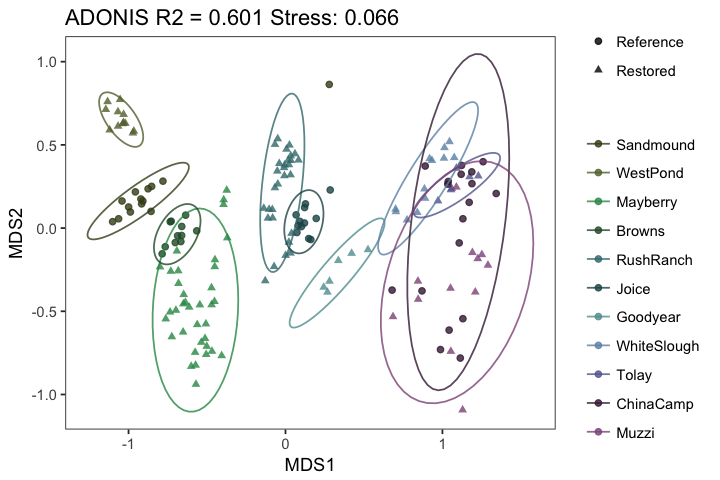

In [27]:
options(repr.plot.width=6, repr.plot.height=4)
mds_site <-biom_plot_cats_nmds(otu_d, Location, Restor, site_col)#, Meta_iTag)
mds_site
# ggsave("SF_Sal_OTU_NMDS_by_site.pdf", mds_site, width = 6, height = 4)

### NMDS with group, shape, default pallete

In [28]:
biom_plot_cats_nmds <- function(biom, group, shape){  # , env)
  biomT<-t(biom)    # Transpose so cols are vars
  
  # Test ADONIS models, extract params
  bT_adonis <- adonis(biomT  ~ group, permutations=99, method="bray");#, data=env);
  R2 <- round(bT_adonis$aov.tab$R2[1], digits=3)
  P <- bT_adonis$aov.tab$"Pr(>F)"[1]
  
  # NMDS
  bT_mds<-metaMDS(biomT[,-1], distance="bray",k=3, trymax=10);                  # run NMDS
  bT_mds_DF = data.frame(MDS1=bT_mds$points[,1], MDS2=bT_mds$points[,2], group)  # Make data frame
  stress=round(bT_mds$stress, digits = 3)                                      # get NMDS stress
  
  # Plot NMDS by assembly group
  pA <- ggplot(bT_mds_DF,aes(x=MDS1, y=MDS2, color=group, shape=shape))+geom_point(alpha = 0.8)+stat_ellipse(level=0.95, alpha = 0.8) +
    ggtitle(paste("ADONIS R2 =", R2, "Stress:", stress));
  #pB <- pA + scale_color_manual(values = c(site_col)) + scale_shape_manual(values=c(19, 17))
  pC <- pA + theme(legend.title=element_blank())
  pD <-pC + theme_bw() + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
                              legend.title=element_blank())  
  return(pD)
}

Square root transformation
Wisconsin double standardization
Run 0 stress 0.06594869 
Run 1 stress 0.06594797 
... New best solution
... Procrustes: rmse 0.0002715782  max resid 0.003093853 
... Similar to previous best
Run 2 stress 0.06582524 
... New best solution
... Procrustes: rmse 0.004572809  max resid 0.05543938 
Run 3 stress 0.06582441 
... New best solution
... Procrustes: rmse 0.0002526999  max resid 0.003075564 
... Similar to previous best
Run 4 stress 0.06594776 
... Procrustes: rmse 0.004588973  max resid 0.05554604 
Run 5 stress 0.06594803 
... Procrustes: rmse 0.004558127  max resid 0.05542896 
Run 6 stress 0.06582569 
... Procrustes: rmse 0.000199678  max resid 0.002347078 
... Similar to previous best
Run 7 stress 0.06594762 
... Procrustes: rmse 0.004554887  max resid 0.05545137 
Run 8 stress 0.06582541 
... Procrustes: rmse 0.0003810564  max resid 0.003448015 
... Similar to previous best
Run 9 stress 0.06594864 
... Procrustes: rmse 0.0045109  max resid 0.05526102 

Too few points to calculate an ellipse


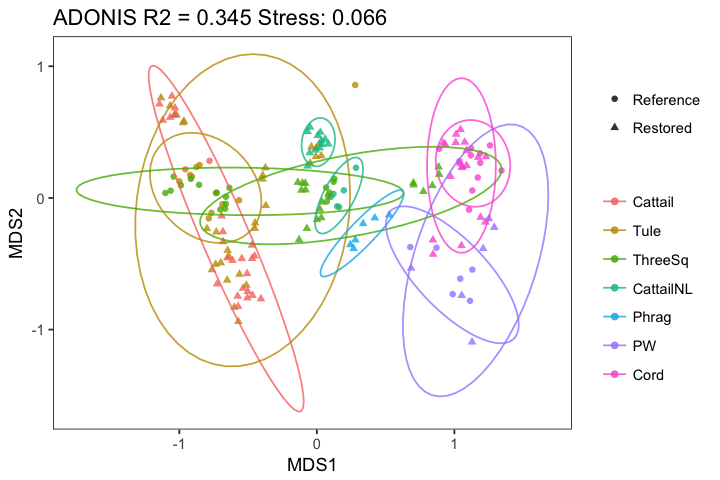

In [29]:
# Make plot 
options(repr.plot.width=6, repr.plot.height=4)
mds_plant_rest <- biom_plot_cats_nmds(otu_d, Plant, Restor)#, Meta_iTag)
mds_plant_rest
#ggsave("SF_Sal_OTU_NMDS_by_plant_rest.pdf", mds_plant_rest, width = 6, height = 4)

### drop shape, causing multiple ellipses

In [30]:
biom_plot_cats_nmds <- function(biom, group){  # , env)
  biomT<-t(biom)    # Transpose so cols are vars
  
  # Test ADONIS models, extract params
  bT_adonis <- adonis(biomT  ~ group, permutations=99, method="bray");#, data=env);
  R2 <- round(bT_adonis$aov.tab$R2[1], digits=3)
  P <- bT_adonis$aov.tab$"Pr(>F)"[1]
  
  # NMDS
  bT_mds<-metaMDS(biomT[,-1], distance="bray",k=3, trymax=10);                  # run NMDS
  bT_mds_DF = data.frame(MDS1=bT_mds$points[,1], MDS2=bT_mds$points[,2], group)  # Make data frame
  stress=round(bT_mds$stress, digits = 3)                                      # get NMDS stress
  
  # Plot NMDS by assembly group
  pA <- ggplot(bT_mds_DF,aes(x=MDS1, y=MDS2, color=group))+geom_point(alpha = 0.8)+stat_ellipse(level=0.95, alpha = 0.8) +
    ggtitle(paste("ADONIS R2 =", R2, "Stress:", stress));
  #pB <- pA + scale_color_manual(values = c(site_col)) + scale_shape_manual(values=c(19, 17))
  pC <- pA + theme(legend.title=element_blank())
  pD <-pC + theme_bw() + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
                              legend.title=element_blank())  
  return(pD)
}

Square root transformation
Wisconsin double standardization
Run 0 stress 0.06594869 
Run 1 stress 0.0658246 
... New best solution
... Procrustes: rmse 0.004577205  max resid 0.05546312 
Run 2 stress 0.06594808 
... Procrustes: rmse 0.004601171  max resid 0.05561539 
Run 3 stress 0.06582623 
... Procrustes: rmse 0.0002766312  max resid 0.002605905 
... Similar to previous best
Run 4 stress 0.06594848 
... Procrustes: rmse 0.004611172  max resid 0.05566407 
Run 5 stress 0.06582474 
... Procrustes: rmse 0.0004041035  max resid 0.003124106 
... Similar to previous best
Run 6 stress 0.06594857 
... Procrustes: rmse 0.004586338  max resid 0.05551572 
Run 7 stress 0.0658252 
... Procrustes: rmse 0.000289227  max resid 0.002161182 
... Similar to previous best
Run 8 stress 0.06594833 
... Procrustes: rmse 0.004537139  max resid 0.05537584 
Run 9 stress 0.06582551 
... Procrustes: rmse 0.0002754597  max resid 0.002608962 
... Similar to previous best
Run 10 stress 0.06582529 
... Procrustes: r

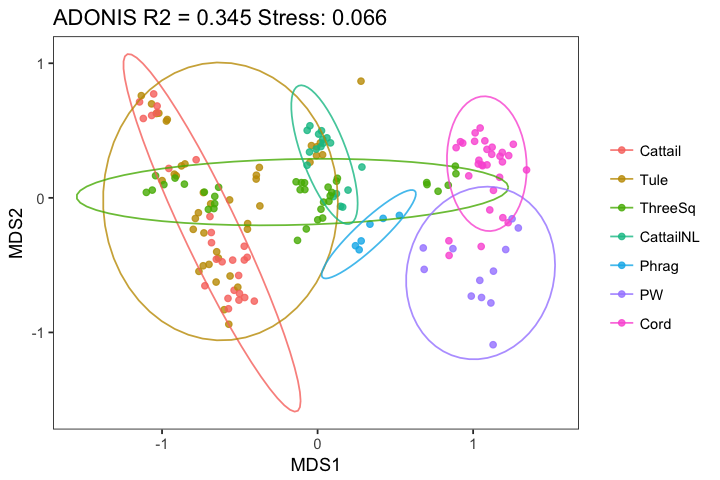

In [31]:
# Make plot 
options(repr.plot.width=6, repr.plot.height=4)
mds_plant <- biom_plot_cats_nmds(otu_d, Plant)#, Meta_iTag)
mds_plant
# ggsave("SF_Sal_OTU_NMDS_by_plant.pdf", mds_plant, width = 6, height = 4)